# 1. Imports and Datasets

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import seaborn as sns
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from keras.utils import timeseries_dataset_from_array
from tensorflow_model_optimization.python.core.keras.compat import keras

sns.set()

The data for the CNN consists of spectrograms of different sounds, such as chainsaw, dog bark, fire-crackling, etc. The spectrograms are stored as PNG files.

In [2]:
!wget -q https://edge-ai-doulos.s3.us-west-2.amazonaws.com/esc_spec.zip
!unzip -q esc_spec

# 2. The Humble Dense Network

There is probably nothing more basic than a dense, fully connected network. Yet, it is still a good starting point to get a feel of how TensorFlow works. Let's predict some Fibonacci numbers with it.

## 2.1 Simple Dense Network

In [3]:
def split_sequence(sequence: list, n_steps_in: int, n_steps_out: int) -> tuple:
    """Split a univariate sequence into samples

    This function takes a univariate sequence and splits it into input-output
    samples based on the specified number of input and output time steps.

    Args:
        sequence (list): The input sequence to split.
        n_steps_in (int): The number of input time steps.
        n_steps_out (int): The number of output time steps.

    Returns:
        tuple: A tuple containing the input samples (X) and the corresponding
        output samples (y).
    """
    x, y = [], []
    for i in range(len(sequence)):
        start_idx = i + n_steps_in
        end_idx = start_idx + n_steps_out
        if end_idx > len(sequence):
            break
        seq_x, seq_y = sequence[i:start_idx], sequence[start_idx:end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [ ]:
# ------------------------------------------------------------------------------
# 1. Prepare the data
# ------------------------------------------------------------------------------

# Fibonacci Series
training_seq = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597]

# Set the number of time steps for input and output of Fibonacci Series

n_steps_in, n_steps_out = 4, 2

# Split the sequence into samples

x, y = split_sequence(training_seq, n_steps_in, n_steps_out)

# ------------------------------------------------------------------------------
# 2. Define the model
# ------------------------------------------------------------------------------

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(n_steps_in,)))
model.add(tf.keras.layers.Dense(units=25, activation="relu"))
model.add(tf.keras.layers.Dense(units=25, activation="relu"))
model.add(tf.keras.layers.Dense(units=n_steps_out))
model.compile(optimizer="adam", loss="mse")

# ------------------------------------------------------------------------------
# 3. Train the model
# ------------------------------------------------------------------------------
model.fit(x, y, epochs=2000, verbose="auto")

In [5]:
# ------------------------------------------------------------------------------
# 4. Make predictions
# ------------------------------------------------------------------------------

x_test = np.array([2584, 4181, 6765, 10946])  # Expected Output: [17711, 28657]
x_test = x_test.reshape((1, n_steps_in))

y_test = model.predict(x_test, verbose=0)
np.allclose(y_test, [[17711.0, 28657.0]], atol=20), f"Unexpected output: got {y_test}, expected [[17711., 28657.]]"

(True,
 'Unexpected output: got [[17705.104 28642.53 ]], expected [[17711., 28657.]]')

Looking at the above losses, it's very likely that we are overfitting the training data. However, since we're doing okay... and this is just a demo, we will not go into techniques to mitigate that later.

## 2.2. DenseNetworks with Time Series Data

In [ ]:
# ------------------------------------------------------------------------------
# 1. Reorganize the data for time series
# ------------------------------------------------------------------------------

training_data_seq = np.array(training_seq)
training_data = timeseries_dataset_from_array(
    data=training_data_seq[:], targets=training_data_seq[3:], sequence_length=3, batch_size=1
)

In [27]:
# Let's see how the data looks like
for inputs, targets in training_data:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[:]))

[0, 1, 1, 2] 3
[1, 1, 2, 3] 5
[1, 2, 3, 5] 8
[2, 3, 5, 8] 13
[3, 5, 8, 13] 21
[5, 8, 13, 21] 34
[8, 13, 21, 34] 55
[13, 21, 34, 55] 89
[21, 34, 55, 89] 144
[34, 55, 89, 144] 233
[55, 89, 144, 233] 377
[89, 144, 233, 377] 610
[144, 233, 377, 610] 987
[233, 377, 610, 987] 1597


In [41]:
# ------------------------------------------------------------------------------
# 3. Model Definitions and Traning
# ------------------------------------------------------------------------------

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(4,)))
model.add(tf.keras.layers.Dense(units=25, activation="relu"))
model.add(tf.keras.layers.Dense(units=25, activation="relu"))
model.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Compile the model
model.compile(optimizer="adamw", loss="mae")

# Train the model
model.fit(training_data, epochs=200, verbose="auto")

Epoch 1/200


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 298.2857
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 298.2857
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 298.2857
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 298.2857
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 298.2857
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 298.2857
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 298.2857
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 298.2857
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 298.2857
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 298.2857
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 298.2857
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 298.2857
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 298.2857
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 298.2857
Epoch 15/200
14/14 ━━━━━━━━

In [24]:
# Let's do a check

x_test = np.array([2584, 4181, 6765])  # Expected Output: [17711, 28657]
x_test = x_test.reshape((1, 3))

y_test = model.predict(x_test, verbose=0)
np.allclose(y_test, [[17711]], atol=20), f"Unexpected output: got {y_test}, expected [[17711.0, 28657.0]]"

(False, 'Unexpected output: got [[10935.676]], expected [[17711.0, 28657.0]]')

# 3. LSTM

This will be pretty standard code. We'll just have to change the shape to [samples, time steps, features] and use an LSTM layer instead of a Dense layer.

In [28]:
# ------------------------------------------------------------------------------
# 1. Prepare the data
# ------------------------------------------------------------------------------

# Harmonic Sequence
harmonic_seq = [1, 0.5, 0.33, 0.25, 0.2, 0.17, 0.14, 0.125, 0.11]

# Number of Time Steps and Features
n_steps = 3
n_features = 1

# Create training dataset

training_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=harmonic_seq[:],
    targets=harmonic_seq[3:],
    sequence_length=3,
    batch_size=1,
)

In [29]:
# ------------------------------------------------------------------------------
# 2. Explore the data
# ------------------------------------------------------------------------------

for inputs, targets in training_dataset:
    for i in range(inputs.shape[0]):
        print([round(x, 3) for x in inputs[i].numpy().flatten()], round(float(targets[i]), 3))

[np.float32(1.0), np.float32(0.5), np.float32(0.33)] 0.25
[np.float32(0.5), np.float32(0.33), np.float32(0.25)] 0.2
[np.float32(0.33), np.float32(0.25), np.float32(0.2)] 0.17
[np.float32(0.25), np.float32(0.2), np.float32(0.17)] 0.14
[np.float32(0.2), np.float32(0.17), np.float32(0.14)] 0.125
[np.float32(0.17), np.float32(0.14), np.float32(0.125)] 0.11


2025-10-06 13:31:13.532718: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
# ------------------------------------------------------------------------------
# 3. Define the model
# ------------------------------------------------------------------------------

use_lstm = True

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(n_steps, n_features)))
if use_lstm:
    model.add(tf.keras.layers.LSTM(units=50, activation="relu"))
else:
    model.add(tf.keras.layers.GRU(units=50, activation="relu"))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------------------------------------------------------
# 4. Train the model
# ------------------------------------------------------------------------------

model.fit(training_dataset, epochs=1000, verbose="auto")

In [39]:
# ------------------------------------------------------------------------------
# 5. Test the model
# ------------------------------------------------------------------------------

x_test = np.array([0.111, 0.1, 0.09])  # Expected Output: [0.0833]
# x_test = np.array([0.14, 0.125, 0.11]) # Expected Output: [0.1]
x_test = x_test.reshape((1, n_steps, n_features))
y_test = model.predict(x_test, verbose=0)
np.allclose(y_test, [[0.0833]], atol=0.01), f"Got {y_test}, expected [[0.0833]]"

(True, 'Got [[0.086839]], expected [[0.0833]]')

# 4. LeNet Style CNN

## 4.1. Data Preparation

In [2]:
# ------------------------------------------------------------------------------
# 1. Data Preparation
# ------------------------------------------------------------------------------

# There are many preprocessing steps one can apply. Here, I will just normalize
# and create the data generators.

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.3)

train_generator = data_generator.flow_from_directory(
    "esc_spec", target_size=(224, 224), batch_size=32, subset="training"
)

validation_generator = data_generator.flow_from_directory(
    "esc_spec", target_size=(224, 224), batch_size=32, subset="validation"
)

# ------------------------------------------------------------------------------
# 2. Define the labels
# ------------------------------------------------------------------------------

labels = "\n".join(sorted(train_generator.class_indices.keys()))
with open("esc_spec_labels.txt", "w") as f:
    f.write(labels)

Found 308 images belonging to 11 classes.
Found 132 images belonging to 11 classes.


In [3]:
# Let's explore the data quickly
image_batch, label_batch = next(train_generator)
print(image_batch.shape, label_batch.shape)
print(image_batch[0].shape, label_batch[0])  # We see we're already getting a 1-hot encoded label

(32, 224, 224, 3) (32, 11)
(224, 224, 3) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
!cat esc_spec_labels.txt

chainsaw
clock-ticking
crowing-rooster
crying-baby
dog-barking
fire-crackling
glass-breaking
helicopter
rain
sea-waves
sneezing

## 4.2. Model Definitions and Traning

In [8]:
# ------------------------------------------------------------------------------
# 1. Define the model
# ------------------------------------------------------------------------------

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(224, 224, 3)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=11, activation="softmax"))

# ------------------------------------------------------------------------------
# 2. Compile the model
# ------------------------------------------------------------------------------

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,092,043 (49.94 MB)

 Trainable params: 13,092,043 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------------------------------------------------------
# 3. Train the model
# ------------------------------------------------------------------------------

training_history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)

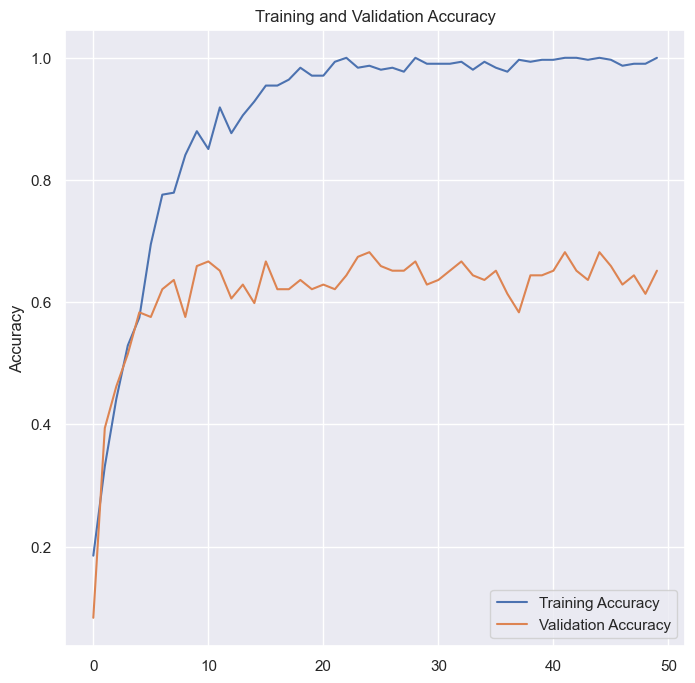

In [10]:
accuracy = training_history.history["accuracy"]
validation_accuracy = training_history.history["val_accuracy"]

plt.figure(figsize=(8, 8))
plt.plot(accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

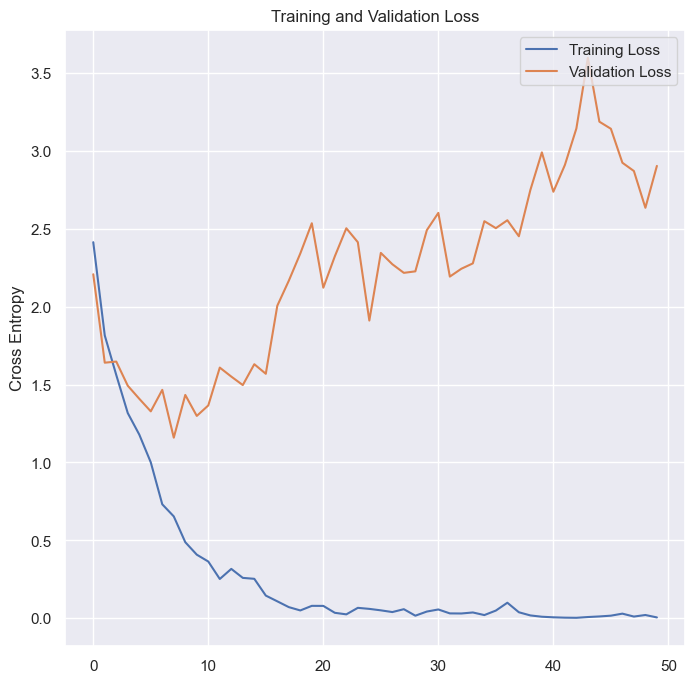

In [11]:
loss = training_history.history["loss"]
validation_loss = training_history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.plot(loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training and Validation Loss")
plt.show()

## 4.3. Model Saving and Evaluation

In [ ]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Make a "models" directory to store the model
os.makedirs("models", exist_ok=True)

with tf.io.gfile.GFile("models/ESC-11-LENET-CNN.tflite", "wb") as f:
    f.write(tflite_model)

# 5. Transfer Learning in TensorFlow: MobileNetV2

In [6]:
# ------------------------------------------------------------------------------
# 1. Create the base model from a pre-trained MobileNet V2
# ------------------------------------------------------------------------------

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

# ------------------------------------------------------------------------------
# 2. Add a classification head
# ------------------------------------------------------------------------------

model_transfer = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=11, activation="softmax"),
])

# ------------------------------------------------------------------------------
# 3. Compile the model
# ------------------------------------------------------------------------------

model_transfer.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_transfer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,019 (10.02 MB)

 Trainable params: 369,035 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ------------------------------------------------------------------------------
# 4. Train the model
# ------------------------------------------------------------------------------

training_history = model_transfer.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)

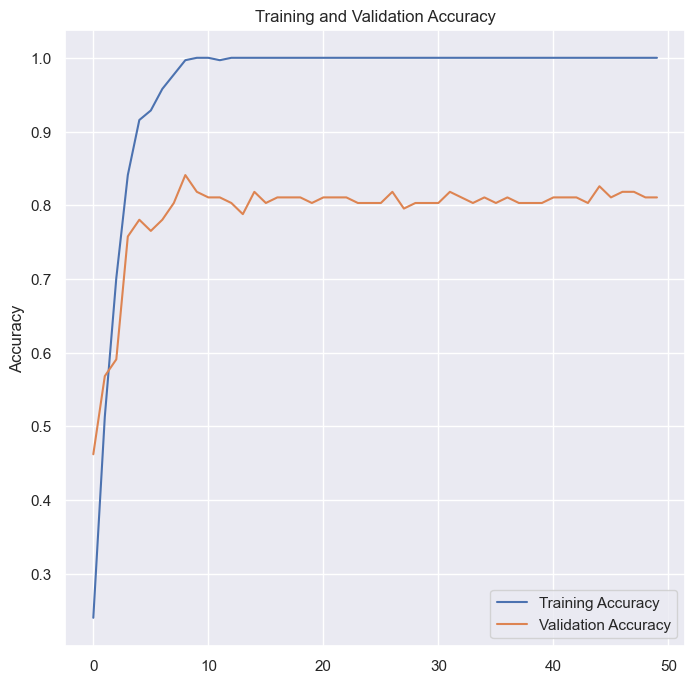

In [8]:
accuracy = training_history.history["accuracy"]
validation_accuracy = training_history.history["val_accuracy"]

plt.figure(figsize=(8, 8))
plt.plot(accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

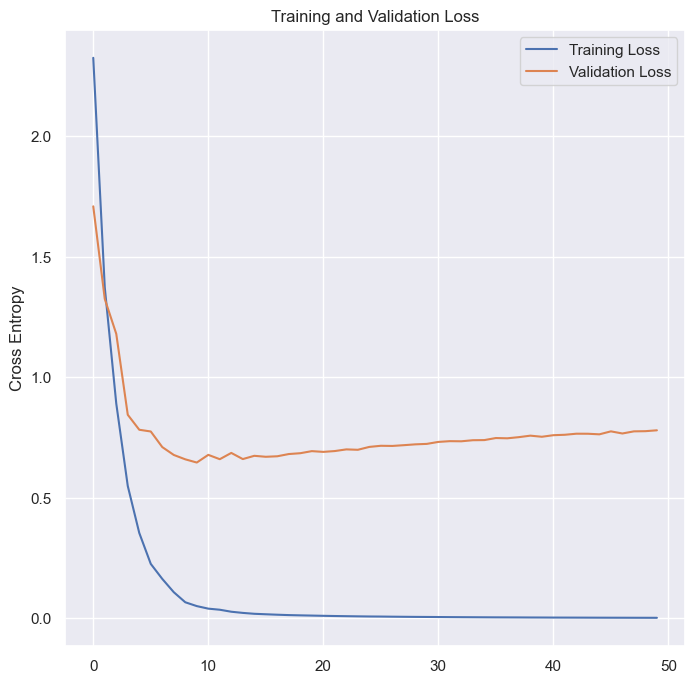

In [9]:
loss = training_history.history["loss"]
validation_loss = training_history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.plot(loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training and Validation Loss")
plt.show()

In [10]:
# ------------------------------------------------------------------------------
# 5. Convert the model to TFLite
# ------------------------------------------------------------------------------

converter = tf.lite.TFLiteConverter.from_keras_model(model_transfer)
tflite_model = converter.convert()

with tf.io.gfile.GFile("models/ESC-11-MobileNet.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpdosmxln0/assets


INFO:tensorflow:Assets written to: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpdosmxln0/assets


Saved artifact at '/var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpdosmxln0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  4968376912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968376528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968377680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968377488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379984: Ten

W0000 00:00:1759997338.416747 1798505 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759997338.416784 1798505 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-09 10:08:58.417091: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpdosmxln0
2025-10-09 10:08:58.422512: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-09 10:08:58.422533: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpdosmxln0
I0000 00:00:1759997338.474433 1798505 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-10-09 10:08:58.485292: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-09 10:08:58.861035: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [11]:
# We can also save the model in SavedModel format or .h5 format
model_transfer.export("models/ESC-11-MobileNet")
model_transfer.save("models/ESC-11-MobileNet.h5")

INFO:tensorflow:Assets written to: models/ESC-11-MobileNet/assets


INFO:tensorflow:Assets written to: models/ESC-11-MobileNet/assets


Saved artifact at 'models/ESC-11-MobileNet'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  4968376912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968376528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968377680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968378640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968377488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4968379984: TensorSpec(shape=(), dtype=tf.resource, 

# 6. Converting Models to ONNX

In [12]:
# # Here, the operation is quite simple. We just load the relavant .h5 model and
# # convert it to ONNX format.

!python -m tf2onnx.convert --saved-model models/ESC-11-MobileNet \
    --opset 18 \
    --output models/ESC-11-MobileNet.onnx

<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-10-09 10:09:08,948 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-10-09 10:09:08,949 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-10-09 10:09:11,303 - INFO - Signatures found in model: [serve,serving_default].
2025-10-09 10:09:11,304 - WARNING - '--signature_def' not specified, using first signature: serve
2025-10-09 10:09:11,304 - INFO - Output names: ['output_0']
I0000 00:00:1759997351.402418 1802976 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1759997351.402760 1802976 single_machine.cc:374] Starting new session
I0000 00:00

In [13]:
# Let's now check if the model runs correctly in ONNX Runtime

session = ort.InferenceSession("models/ESC-11-MobileNet.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Let's do a quick check with a random input
x_test = np.random.rand(1, 224, 224, 3).astype(np.float32)
y_test = session.run([output_name], {input_name: x_test})
print(y_test[0].shape)  # We expect (1, 11)

(1, 11)


In [14]:
# Looks promising. Let's check the onnx with Netron

!netron models/ESC-11-MobileNet.onnx

# > Note: To stop this, you will need to interrupt the kernel or stop the cell execution.

Serving 'models/ESC-11-MobileNet.onnx' at http://localhost:8080
^C


In [15]:
# We can also do this from a tflite model, but it is a bit more involving:

!python -m tf2onnx.convert --tflite models/ESC-11-MobileNet.tflite \
  --opset 18 \
  --output models/ESC-11-MobileNet_fromTFLite.onnx
# add --dequantize if your backend lacks Q ops

<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-10-09 10:09:38,787 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-10-09 10:09:38,789 - INFO - Using tensorflow=2.19.1, onnx=1.17.0, tf2onnx=1.16.1/4fed7d
2025-10-09 10:09:38,789 - INFO - Using opset <onnx, 18>
/Users/andreiroibu/Learning/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delega

In [16]:
# Let's now check if the model runs correctly in ONNX Runtime

session = ort.InferenceSession("models/ESC-11-MobileNet_fromTFLite.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Let's do a quick check with a random input
x_test = np.random.rand(1, 224, 224, 3).astype(np.float32)
y_test = session.run([output_name], {input_name: x_test})
print(y_test[0].shape)  # We expect (1, 11)
print(output_name)

(1, 11)
StatefulPartitionedCall_1:0


# 7. Quantization

## 7.1. Post-Training Quantization

There are 3 types of post-training quantization available in TensorFlow Lite:
- Dynamic Range Quantization
- Full Integer Quantization
- Float16 Quantization

Because I am targetting a microcontroller, I will use Full Integer Quantization.

In [23]:
# ------------------------------------------------------------------------------
# 1. Define a representative repressentative dataset
# ------------------------------------------------------------------------------
# For full integer quantization, we need to calibrate or estimate the range,
# i.e., (min, max) of all floating-point tensors in the model. Unlike constant
# tensors such as weights and biases, variable tensors such as model input,
# activations (outputs of intermediate layers) and model output cannot be
# calibrated unless we run a few inference cycles. As a result, the converter
# requires a representative dataset to calibrate them. This dataset can be a
# small subset (around ~100-500 samples) of the training or validation data.
# Here, I use the validation data.


def representative_dataset():
    for idx, (x, _) in enumerate(validation_generator):
        if idx >= 100:
            break
        yield [x]


# ------------------------------------------------------------------------------
# 2. Convert the model
# ------------------------------------------------------------------------------

saved_model_dir = "models/ESC-11-MobileNet"  # The SavedModel format

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# If the model input and output are floats, the following lines are not needed.
# However, if you want to have int8 input and output, then we will need them.
# ---
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
# ---

tflite_quant_model = converter.convert()

W0000 00:00:1759998538.261993 1798505 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759998538.262018 1798505 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-09 10:28:58.262279: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/ESC-11-MobileNet
2025-10-09 10:28:58.267404: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-09 10:28:58.267426: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: models/ESC-11-MobileNet
2025-10-09 10:28:58.332415: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-09 10:28:58.706841: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: models/ESC-11-MobileNet
2025-10-09 10:28:58.804627: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 542347 microseconds.
fully_quantize: 0, infe

In [24]:
# ------------------------------------------------------------------------------
# 3. Save the quantized model
# ------------------------------------------------------------------------------

with tf.io.gfile.GFile("models/ESC-11-MobileNet-FullIntegerQuant.tflite", "wb") as f:
    f.write(tflite_quant_model)

In [10]:
# ------------------------------------------------------------------------------
# 4. Do an inference pass with the quantized model to see if it works
# ------------------------------------------------------------------------------

interpreter = tf.lite.Interpreter(model_path="models/ESC-11-MobileNet-FullIntegerQuant.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_shape = input_details[0]["shape"]
input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)

# Set the tensor
interpreter.set_tensor(input_details[0]["index"], input_data)

# Run the inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]["index"])

print(output_data)
print(output_data.shape)  # We expect (1, 11)

[[-128 -128 -128 -128 -128 -128  -65   63 -128 -128 -126]]
(1, 11)


## 7.2. Quantization Aware Training

In [ ]:
# ------------------------------------------------------------------------------
# 1. Perform the first round of training with floats
# ------------------------------------------------------------------------------
# First, we do a quantization aware training. Importantly, after this the model
# is not quantized yet (ie. weights are still in float32). We will move them to
# int8 in the next step.

quantize_model = tfmot.quantization.keras.quantize_model

# We apply quantization aware training to our full model. This will require a
# recompilation and retraining of the model. Making a small change to the model,
# building it with Keras instead of TF-Keras, due to issues with the library.

# We also cannot define one keras model inside another keras model, so we
# redefine the whole model here.

inputs = keras.Input(shape=(224, 224, 3))

base_model = keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units=11, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)

Epoch 1/50
10/10 [==============================] - 5s 264ms/step - loss: 2.0509 - accuracy: 0.3442 - val_loss: 1.3608 - val_accuracy: 0.5152
Epoch 2/50
10/10 [==============================] - 2s 178ms/step - loss: 0.9705 - accuracy: 0.6948 - val_loss: 0.9850 - val_accuracy: 0.6818
Epoch 3/50
10/10 [==============================] - 2s 175ms/step - loss: 0.5689 - accuracy: 0.8312 - val_loss: 0.8483 - val_accuracy: 0.7348
Epoch 4/50
10/10 [==============================] - 2s 173ms/step - loss: 0.3636 - accuracy: 0.9058 - val_loss: 0.7770 - val_accuracy: 0.7273
Epoch 5/50
10/10 [==============================] - 2s 166ms/step - loss: 0.2142 - accuracy: 0.9513 - val_loss: 0.7772 - val_accuracy: 0.7652
Epoch 6/50
10/10 [==============================] - 2s 178ms/step - loss: 0.1522 - accuracy: 0.9578 - val_loss: 0.7847 - val_accuracy: 0.7500
Epoch 7/50
10/10 [==============================] - 2s 166ms/step - loss: 0.1058 - accuracy: 0.9805 - val_loss: 0.7792 - val_accuracy: 0.7500
Epoch 

In [ ]:
# ------------------------------------------------------------------------------
# 2. Create a quantization aware model
# ------------------------------------------------------------------------------
# Now, we create a quantization aware model from the trained float model.
# Quantization aware training (QAT) will add fake quantization
# operations to the model, which will simulate the effects of quantization
# during training. This allows the model to adapt to the quantization effects,
# leading to better accuracy when the model is quantized.
Q = tfmot.quantization.keras

# Create the QAT clone (weights are copied from 'model')
q_aware_model = Q.quantize_model(model)

# Compile with a lower LR (typical: 1e-4 to 1e-5) and same loss/metrics
q_aware_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

q_aware_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 quantize_layer_5 (Quantize  (None, 224, 224, 3)          3         ['input_12[0][0]']            
 Layer)                                                                                           
                                                                                                  
 quant_Conv1 (QuantizeWrapp  (None, 112, 112, 32)         929       ['quantize_layer_5[0][0]']    
 erV2)                                                                                            
                                                                                            

In [35]:
# Fine-tune a little (e.g., 2-10 epochs). Keep your val data the same.
q_aware_model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=10,  # start small; early-stop if you like
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)

Epoch 1/10
10/10 [==============================] - 17s 981ms/step - loss: 2.3706 - accuracy: 0.2565 - val_loss: 1.9597 - val_accuracy: 0.2955
Epoch 2/10
10/10 [==============================] - 7s 743ms/step - loss: 1.7093 - accuracy: 0.3701 - val_loss: 1.4967 - val_accuracy: 0.5076
Epoch 3/10
10/10 [==============================] - 8s 798ms/step - loss: 1.2897 - accuracy: 0.6039 - val_loss: 1.2412 - val_accuracy: 0.6061
Epoch 4/10
10/10 [==============================] - 9s 938ms/step - loss: 0.8747 - accuracy: 0.7403 - val_loss: 0.9530 - val_accuracy: 0.6591
Epoch 5/10
10/10 [==============================] - 9s 868ms/step - loss: 0.6136 - accuracy: 0.8312 - val_loss: 0.8443 - val_accuracy: 0.7045
Epoch 6/10
10/10 [==============================] - 8s 827ms/step - loss: 0.4178 - accuracy: 0.9091 - val_loss: 0.7770 - val_accuracy: 0.7121
Epoch 7/10
10/10 [==============================] - 10s 975ms/step - loss: 0.2915 - accuracy: 0.9416 - val_loss: 0.9148 - val_accuracy: 0.7197
Epoc

In [ ]:
# ------------------------------------------------------------------------------
# 3. Convert the QAT model to a quantized TFLite model
# ------------------------------------------------------------------------------

# With QAT, TFLite already has learned quantized params, so a representative
# dataset is optional. We can still provide one.


def representative_data_gen(n_samples=200):
    remaining = n_samples
    for images, _ in train_generator:
        for i in range(min(remaining, images.shape[0])):
            # TFLite expects a list of input tensors shaped like real inference
            yield [images[i : i + 1].astype(np.float32)]
        remaining -= images.shape[0]
        if remaining <= 0:
            break


converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Optional with QAT:
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantized_tflite_model = converter.convert()

# Save the quantized model
with tf.io.gfile.GFile("models/ESC-11-MobileNet-QAT-QAT.tflite", "wb") as f:
    f.write(quantized_tflite_model)

INFO:tensorflow:Assets written to: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpmtvuz3bv/assets


INFO:tensorflow:Assets written to: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpmtvuz3bv/assets
/Users/andreiroibu/Learning/.venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1760464589.714272  759822 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1760464589.714294  759822 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-14 19:56:29.714518: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpmtvuz3bv
2025-10-14 19:56:29.745060: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-14 19:56:29.745083: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/rk/fntg8jss1sxgzh96prwfgcfc0000gn/T/tmpmtvuz3bv
2025-10-14 19:56:29.910563: I tens

In [ ]:
# ------------------------------------------------------------------------------
# 4. Do an inference pass with the quantized model to see if it works
# ------------------------------------------------------------------------------

interpreter = tf.lite.Interpreter(model_path="models/ESC-11-MobileNet-QAT-QAT.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_shape = input_details[0]["shape"]
input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)

# Set the tensor
interpreter.set_tensor(input_details[0]["index"], input_data)

# Run the inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]["index"])

print(output_data)
print(output_data.shape)  # We expect (1, 11)

[[-127 -109 -120 -128 -126 -128   92 -128 -127 -125 -127]]
(1, 11)


In [ ]:
# ------------------------------------------------------------------------------
# 5. Check model sizes
# ------------------------------------------------------------------------------

for model_file in os.listdir("models"):
    model_path = os.path.join("models", model_file)
    size_kb = os.path.getsize(model_path) / 1024
    print(f"{model_file:40s}: {size_kb:8.2f} KB")

ESC-11-MobileNet.onnx                   : 10155.04 KB
ESC-11-MobileNet                        :     0.19 KB
ESC-11-MobileNet-FullIntegerQuant.tflite:  3007.14 KB
ESC-11-MobileNet_fromTFLite.onnx        : 10128.15 KB
ESC-11-MobileNet.h5                     : 13508.26 KB
ESC-11-MobileNet.tflite                 : 10098.16 KB
ESC-11-MobileNet-QAT-QAT.tflite         :  3002.47 KB


# 8. Clean Up

In [40]:
# Cleanup the data folder
items = ["esc_spec", "esc_spec.zip", "esc_spec_labels.txt"]
for item in items:
    if os.path.isdir(item):
        shutil.rmtree(item)
    elif os.path.isfile(item):
        os.remove(item)